In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import exoplanet as xo
import corner

import pymc3 as pm
import theano.tensor as tt

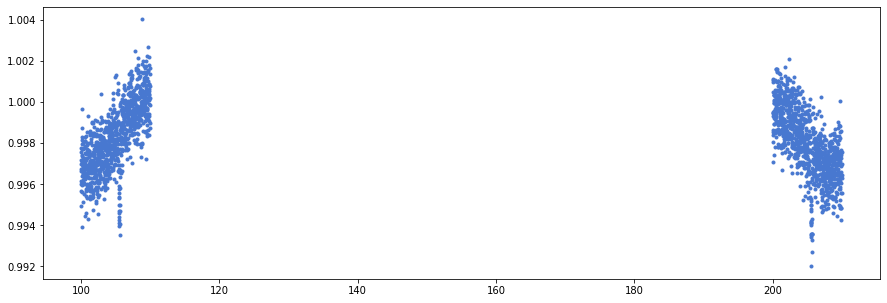

In [14]:
x = np.concatenate((np.arange(100,110,0.01), np.arange(200,210,0.01)))

#Adding some randomised sinusoids to mimic stellar variability:
y_sv=abs(np.random.normal(0.002,0.0005))*np.sin((x+np.random.random()*2*np.pi)/(np.random.normal(8,1)))+abs(np.random.normal(0.001,0.0005))*np.sin((x+np.random.random()*2*np.pi)/(np.random.normal(3,0.8)))

y = np.concatenate((np.random.normal(1.0,0.001,1000), np.random.normal(1.0,0.001,1000)))+y_sv
yerr = 0.001 + np.zeros_like(y)

t0s=[105.57, 205.57]

true_orbit = xo.orbits.KeplerianOrbit(period=100/3.0, t0=t0s[0], b=0.3, omega=0.72, ecc=0.025)
true_model = xo.LimbDarkLightCurve([0.3, 0.2]).get_light_curve(orbit=true_orbit, t=x, r=np.sqrt(0.00325))[:, 0].eval()
y += true_model

plt.figure(figsize=(15,5))
plt.plot(x, y,'.');

In [15]:
#Here we compute the max period and the min period
dur=0.24
max_P=t0s[1]-t0s[0]

#Folding x on maximum period with the first transit at 0.0
folded_x=np.sort(abs((x-t0s[0]-max_P*0.5)%max_P-max_P*0.5))

#minimum P is the first instance of a gap bigger than the duration in absolute phase space:
min_P=np.where(np.diff(folded_x)>dur)[0]
min_P=min_P[0] if len(min_P)>1 else min_P
min_P=np.max(folded_x) if len(min_P)==0 else min_P
period_index = np.arange(1, max_P/min_P, 1)

In [8]:
period_index

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17.])

array([100.        ,  50.        ,  33.33333333,  25.        ,
        20.        ,  16.66666667,  14.28571429,  12.5       ,
        11.11111111,  10.        ,   9.09090909,   8.33333333,
         7.69230769,   7.14285714,   6.66666667,   6.25      ,
         5.88235294])

# Let's see if the output corner plots from different periods are significantly different...

In [9]:
import seaborn as sns
sns.set_palette("muted")

In [44]:
with pm.Model() as model:

    # The time of a reference time for each transit
    t0_1 = pm.Normal("t0_1", mu=t0s[0], sd=1.0)
    t0_2 = pm.Normal("t0_2", mu=t0s[1], sd=1.0)

    #Stellar stuff
    Rs = pm.Normal("Rs", mu=1.0, sd=0.3)
    logrho_S = pm.Normal("logrho_S", mu=0.0, sd=0.5)
    rho_S = pm.Deterministic("rho_S",tt.exp(logrho_S))

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))

    r = pm.Uniform("r", lower=0.001, upper=0.3)
    ror=pm.Deterministic("ror", r/Rs)
    b = xo.distributions.ImpactParameter("b", ror=ror, testval=0.41)

    periods = pm.Deterministic("periods", (t0_2 - t0_1) / period_index)

    #Initialising eccentricity and omega:
    BoundedBeta = pm.Bound(pm.Beta, lower=1e-5, upper=1-1e-5)
    ecc = BoundedBeta("ecc", alpha=0.867, beta=3.03)
    omega = xo.distributions.Angle("omega")
    period = i

    #Jitter term. Initialised with the std of y
    logs2 = pm.Normal("logs2", mu=np.log(np.std(y)),sd=1.0,testval=np.log(np.std(y)))

    #Guess P_var=10d to begin:
    logw0_guess = np.log(2*np.pi/10)

    #freq bounded from 2pi/minimum_cadence to to 2pi/(4x lc length)
    min_cad=np.nanmedian(np.diff(x))#Limiting to <1 cadence
    lcrange=x[-1]-x[0]
    logw0 = pm.Uniform("logw0",lower=np.log((2*np.pi)/(4*lcrange)), 
                       upper=np.log((2*np.pi)/min_cad),testval=logw0_guess)

    # S_0 directly because this removes some of the degeneracies between
    # S_0 and omega_0 prior=(-0.25*lclen)*exp(logS0)
    logpower = pm.Uniform("logpower",lower=-20,upper=np.log(np.nanmedian(abs(np.diff(y)))),testval=-10)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

    # Initialising GP model for the light curve
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
    gp = xo.gp.GP(kernel, x, tt.exp(logs2) + tt.zeros(len(x)), J=2)

    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0_1, b=b,
                                     ecc=ecc,omega=omega)

    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=x)
    light_curve = pm.Deterministic("light_curve", pm.math.sum(light_curves, axis=-1))
    
    llk_gp = pm.Potential("transit_obs", gp.log_likelihood(y - light_curve))
    gp_pred = pm.Deterministic("gp_pred", gp.predict())

    map_soln_gp_marg_ecc = xo.optimize(vars=[r, b])
    map_soln_gp_marg_ecc = xo.optimize(start=map_soln_gp_marg_ecc, vars=[logs2])
    map_soln_gp_marg_ecc = xo.optimize(start=map_soln_gp_marg_ecc, vars=[t0_1, t0_2])
    map_soln_gp_marg_ecc = xo.optimize(start=map_soln_gp_marg_ecc, vars=[logs2, logpower])
    map_soln_gp_marg_ecc = xo.optimize(start=map_soln_gp_marg_ecc, vars=[logw0])
    map_soln_gp_marg_ecc = xo.optimize(start=map_soln_gp_marg_ecc, vars=[r,b,ecc,Rs,u])
    map_soln = xo.optimize(map_soln_gp_marg_ecc)


optimizing logp for variables: [b, r, Rs]

0it [00:00, ?it/s]/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])

0it [00:00, ?it/s, logp=-1.655444e+04]
1it [00:00, 166.28it/s, logp=-1.655444e+04]
2it [00:00, 237.42it/s, logp=-1.655444e+04]
3it [00:00, 269.83it/s, logp=-1.654610e+04]
4it [00:00, 291.25it/s, logp=-1.654631e+04]
5it [00:00, 309.66it/s, logp=-1.654579e+04]
6it [00:00, 315.25it/s, logp=-1.654525e+04]
7it [00:00, 325.29it/s, logp=-1.654461e+04]
8it [00:00, 331.66it/s, logp=-1.654457e+04]
9it [00:00, 338.28it/s, logp=-1.654455e+04]
10it [00:00, 341.19it/s, logp=-1.654455e+04]
11it [00:00, 339.04it/s, logp=-1.654455e+04]
12it [00:00, 338.93it/s, logp=-

120it [00:00, 215.75it/s, logp=1.081204e+04]
121it [00:00, 215.75it/s, logp=1.081204e+04]
122it [00:00, 215.75it/s, logp=1.081204e+04]
123it [00:00, 215.75it/s, logp=1.081204e+04]
124it [00:00, 215.75it/s, logp=1.081204e+04]
125it [00:00, 215.75it/s, logp=1.081204e+04]
126it [00:00, 215.75it/s, logp=1.081204e+04]
127it [00:00, 215.75it/s, logp=1.081204e+04]
128it [00:00, 215.75it/s, logp=1.081204e+04]
129it [00:00, 215.75it/s, logp=1.081204e+04]
130it [00:00, 215.75it/s, logp=1.081204e+04]
131it [00:00, 215.75it/s, logp=1.081204e+04]
132it [00:00, 215.75it/s, logp=1.081204e+04]
133it [00:00, 215.75it/s, logp=1.081204e+04]
134it [00:00, 215.75it/s, logp=1.081204e+04]
135it [00:00, 215.75it/s, logp=1.081204e+04]
136it [00:00, 215.75it/s, logp=1.081204e+04]
137it [00:00, 215.75it/s, logp=1.081204e+04]
138it [00:00, 215.75it/s, logp=1.081204e+04]
139it [00:00, 215.75it/s, logp=1.081204e+04]
140it [00:00, 215.75it/s, logp=1.081204e+04]
141it [00:00, 215.75it/s, logp=1.081204e+04]
142it [00:

No handles with labels found to put in legend.
No handles with labels found to put in legend.


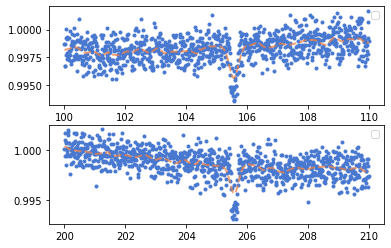

In [11]:
plt.subplot(211)
plt.plot(x[:1000],y[:1000],'.')
plt.plot(x[:1000],map_soln["light_curve"][:1000]+map_soln["gp_pred"][:1000],'--',alpha=0.75,linewidth=2.0)
plt.legend()

plt.subplot(212)
plt.plot(x[1000:],y[1000:],'.')
plt.plot(x[1000:],map_soln["light_curve"][1000:]+map_soln["gp_pred"][1000:],'--',alpha=0.75,linewidth=2.0)
plt.legend()

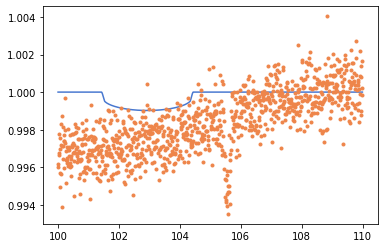

In [20]:
plt.plot(x[:1000],1.0+map_soln["light_curve"][1000:])
plt.plot(x[:1000],y[:1000],'.')

In [12]:
import pickle

In [8]:
print("TESS")

TESS


In [71]:
per=100

with pm.Model() as model:

    # The time of a reference time for each transit#[105.57, 205.57]
    t0_1 = pm.Normal("t0_1", mu=105.57, sd=0.1)
    t0_2 = pm.Normal("t0_2", mu=205.57, sd=0.1)

    #Stellar stuff
    Rs = pm.Normal("Rs", mu=1.0, sd=0.3)
    logrho_S = pm.Normal("logrho_S", mu=0.0, sd=0.5)
    rho_S = pm.Deterministic("rho_S",tt.exp(logrho_S))

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))

    r = pm.Uniform("r", lower=0.01, upper=0.1,  testval=np.sqrt(0.00325))
    b = xo.distributions.ImpactParameter("b", ror=r, testval=0.41)

    #Initialising eccentricity and omega:
    BoundedBeta = pm.Bound(pm.Beta, lower=1e-5, upper=1-1e-5)
    ecc = BoundedBeta("ecc", alpha=0.867, beta=3.03)
    omega = xo.distributions.Angle("omega")
    period = per

    #Jitter term. Initialised with the std of y
    logs2 = pm.Normal("logs2", mu=np.log(np.var(y)),sd=1.0,testval=np.log(np.var(y)))

    #Guess P_var=20d to begin:
    logw0_guess = np.log(2*np.pi/20)

    #freq bounded from 2pi/minimum_cadence to to 2pi/(4x lc length)
    min_cad=np.nanmedian(np.diff(x))#Limiting to <1 cadence
    lcrange=x[-1]-x[0]
    logw0 = pm.Uniform("logw0",lower=np.log((2*np.pi)/(4*lcrange)), 
                       upper=np.log((2*np.pi)/min_cad),testval=logw0_guess)

    # S_0 directly because this removes some of the degeneracies between
    # S_0 and omega_0 prior=(-0.25*lclen)*exp(logS0)
    logpower = pm.Uniform("logpower",lower=-20,upper=np.log(np.nanmedian(abs(np.diff(y)))),testval=-10)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

    # Initialising GP model for the light curve
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
    gp = xo.gp.GP(kernel, x, tt.exp(logs2) + tt.zeros(len(x)), J=2)

    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0_1, b=b,
                                     ecc=ecc,omega=omega)

    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=x)
    light_curve = pm.Deterministic("light_curve", pm.math.sum(light_curves, axis=-1))

    llk_gp = pm.Potential("transit_obs", gp.log_likelihood(y - light_curve))
    gp_pred = pm.Deterministic("gp_pred", gp.predict())

    map_soln_gp_marg_ecc = xo.optimize(vars=[r, b])
    map_soln_gp_marg_ecc = xo.optimize(start=map_soln_gp_marg_ecc, vars=[logs2])
    map_soln_gp_marg_ecc = xo.optimize(start=map_soln_gp_marg_ecc, vars=[t0_1, t0_2])
    map_soln_gp_marg_ecc = xo.optimize(start=map_soln_gp_marg_ecc, vars=[ecc, omega])
    map_soln_gp_marg_ecc = xo.optimize(start=map_soln_gp_marg_ecc, vars=[logs2, logpower])
    map_soln_gp_marg_ecc = xo.optimize(start=map_soln_gp_marg_ecc, vars=[logw0])
    map_soln_gp_marg_ecc = xo.optimize(start=map_soln_gp_marg_ecc, vars=[r,b,ecc,omega,Rs,u])
    map_soln = xo.optimize(map_soln_gp_marg_ecc)

optimizing logp for variables: [b, r]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=8.456080e+03]
1it [00:00, 194.03it/s, logp=8.456080e+03]
2it [00:00, 264.03it/s, logp=8.456080e+03]
3it [00:00, 281.91it/s, logp=8.466723e+03]
4it [00:00, 302.73it/s, logp=8.466984e+03]
5it [00:00, 319.23it/s, logp=8.467415e+03]
6it [00:00, 327.23it/s, logp=8.467691e+03]
7it [00:00, 327.70it/s, logp=8.467776e+03]
8it [00:00, 335.43it/s, logp=8.467786e+03]
9it [00:00, 338.40it/s, logp=8.467789e+03]
10it [00:00, 333.68it/s, logp=8.467789e+03]
11it [00:00, 324.08it/s, logp=8.467789e+03]
12it [00:00, 308.88it/s, logp=8.467789e+03]
14it [00:00, 14.76it/s, logp=8.467789e+03] 
message: Optimization terminated successfully.
logp: 8456.08015554442 -> 8467.789445830018
optimizing logp for variables: [logs2]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=8.467789e+03]
1it [00:00, 229.03it/s, logp=8.467789e+03]
2it [00:00, 312.39it/s, logp=8.467789e+03]
3it [00:00, 346.82it/s, logp=8.756080e+03]
4it [00:00, 355.30it/s, 


130it [00:00, 279.51it/s, logp=8.761158e+03]
131it [00:00, 279.51it/s, logp=8.761158e+03]
132it [00:00, 279.51it/s, logp=8.761158e+03]
133it [00:00, 279.51it/s, logp=8.761158e+03]
134it [00:00, 279.51it/s, logp=8.761158e+03]
135it [00:00, 279.51it/s, logp=8.761158e+03]
136it [00:00, 279.51it/s, logp=8.761158e+03]
137it [00:00, 279.51it/s, logp=8.761158e+03]
138it [00:00, 279.51it/s, logp=8.761158e+03]
139it [00:00, 279.51it/s, logp=8.761158e+03]
140it [00:00, 279.51it/s, logp=8.761158e+03]
141it [00:00, 279.51it/s, logp=8.761158e+03]
142it [00:00, 282.93it/s, logp=8.761158e+03]/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
142it [00:01, 97.07it/s, logp=8.7

15it [00:00, 344.13it/s, logp=8.774160e+03]
16it [00:00, 344.25it/s, logp=8.776700e+03]
17it [00:00, 345.78it/s, logp=8.779045e+03]/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])

18it [00:00, 344.53it/s, logp=8.779110e+03]
19it [00:00, 346.85it/s, logp=8.779356e+03]
20it [00:00, 348.38it/s, logp=8.779751e+03]
21it [00:00, 351.16it/s, logp=8.779966e+03]
22it [00:00, 352.66it/s, logp=8.780110e+03]
23it [00:00, 355.57it/s, logp=8.780171e+03]
24it [00:00, 357.51it/s, logp=8.780213e+03]
25it [00:00, 358.48it/s, logp=8.780333e+03]
26it [00:00, 356.94it/s, logp=8.780586e+03]
27it [00:00, 356.99it/s, logp=8.780828e+03]
28it [00:00, 358.27it/s, logp=8.780670e+03]
29

40it [00:00, 310.41it/s, logp=1.076105e+04]
41it [00:00, 310.41it/s, logp=1.076105e+04]
42it [00:00, 310.41it/s, logp=1.076106e+04]
43it [00:00, 310.41it/s, logp=1.076106e+04]
44it [00:00, 310.41it/s, logp=1.076106e+04]
45it [00:00, 310.41it/s, logp=1.076106e+04]
46it [00:00, 310.41it/s, logp=1.076106e+04]
47it [00:00, 310.41it/s, logp=1.076106e+04]
48it [00:00, 310.41it/s, logp=1.076106e+04]
49it [00:00, 310.41it/s, logp=1.076106e+04]
50it [00:00, 310.41it/s, logp=1.076106e+04]
51it [00:00, 310.41it/s, logp=1.076106e+04]
52it [00:00, 310.41it/s, logp=1.076106e+04]
53it [00:00, 310.41it/s, logp=1.076107e+04]
54it [00:00, 310.41it/s, logp=1.076107e+04]
55it [00:00, 310.41it/s, logp=1.076107e+04]
56it [00:00, 310.41it/s, logp=1.076107e+04]
57it [00:00, 310.41it/s, logp=1.076107e+04]
58it [00:00, 310.41it/s, logp=1.076107e+04]
59it [00:00, 310.41it/s, logp=1.076107e+04]
60it [00:00, 310.41it/s, logp=1.076107e+04]
61it [00:00, 310.41it/s, logp=1.076107e+04]
62it [00:00, 310.41it/s, logp=1.

In [72]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=1200,
        draws=600,
        start=map_soln,
        chains=4,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logpower, logw0, logs2, omega, ecc, b, r, u, logrho_S, Rs, t0_2, t0_1]
INFO:pymc3:NUTS: [logpower, logw0, logs2, omega, ecc, b, r, u, logrho_S, Rs, t0_2, t0_1]

Sampling 4 chains, 0 divergences:   3%|▎         | 249/7200 [00:16<05:51, 19.79draws/s]


Sampling 4 chains, 0 divergences:   8%|▊         | 546/7200 [00:31<03:12, 34.60draws/s]


Sampling 4 chains, 0 divergences:  13%|█▎        | 942/7200 [00:44<02:38, 39.60draws/s]


Sampling 4 chains, 0 divergences:  25%|██▍       | 1794/7200 [00:55<00:46, 115.32draws/s]


Sampling 4 chains, 0 divergences:  40%|███▉      | 2879/7200 [01:05<00:36, 118.44draws/s]


Sampling 4 chains, 1 divergences:  59%|█████▉    | 4269/7200 [01:14<00:19, 146.63draws/s]


Sampling 4 chains, 10 divergences:  76%|███████▌  | 5485/7200 [01:23<00:15, 109.08draws/s]


Sampling 4 chains, 19 divergences:  89%|████████▉ | 6436/7200 [01:32<00:08, 85.08draws/s]


Sampling 4 chains, 31 divergences:  98%|█████████▊| 7092/7200 [01:42<00:02, 47.03draws/s]


Sampling 4 chains, 33 divergences: 100%|██████████| 7200/7200 [01:44<00:00, 68.89draws/s]
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


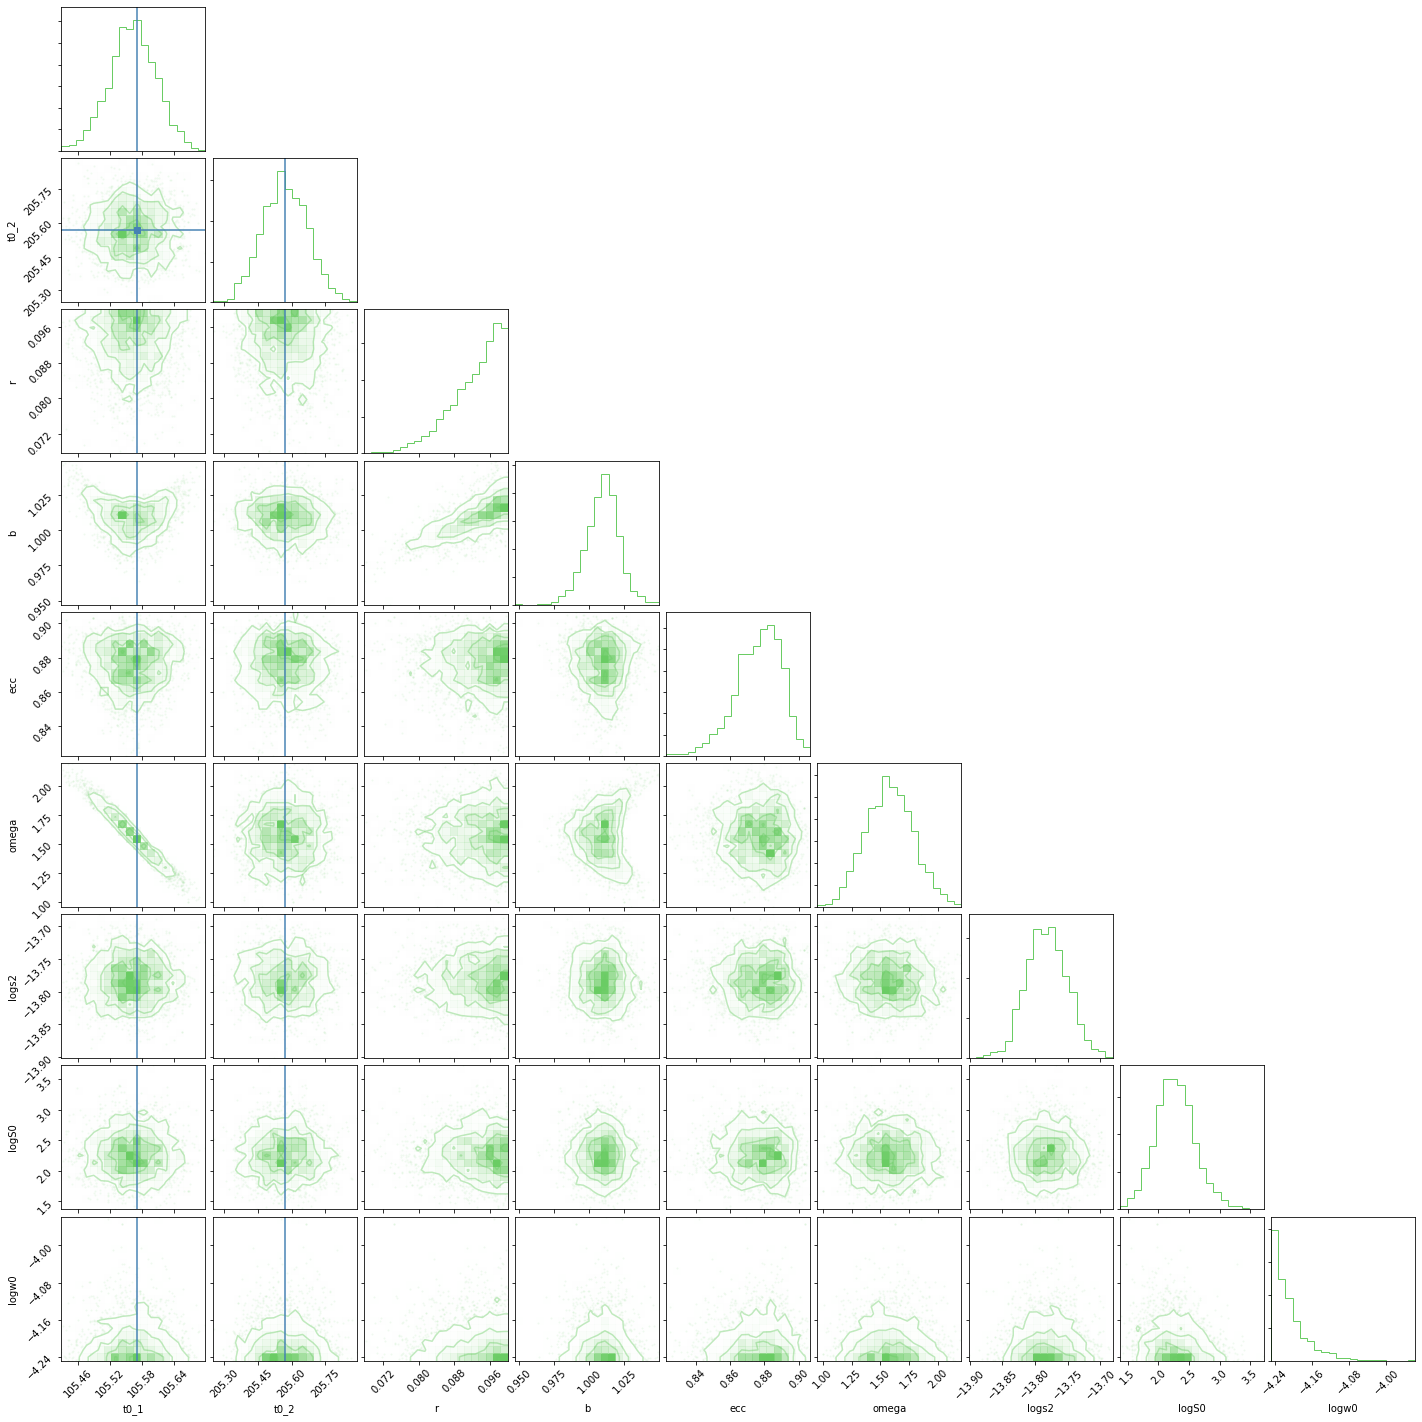

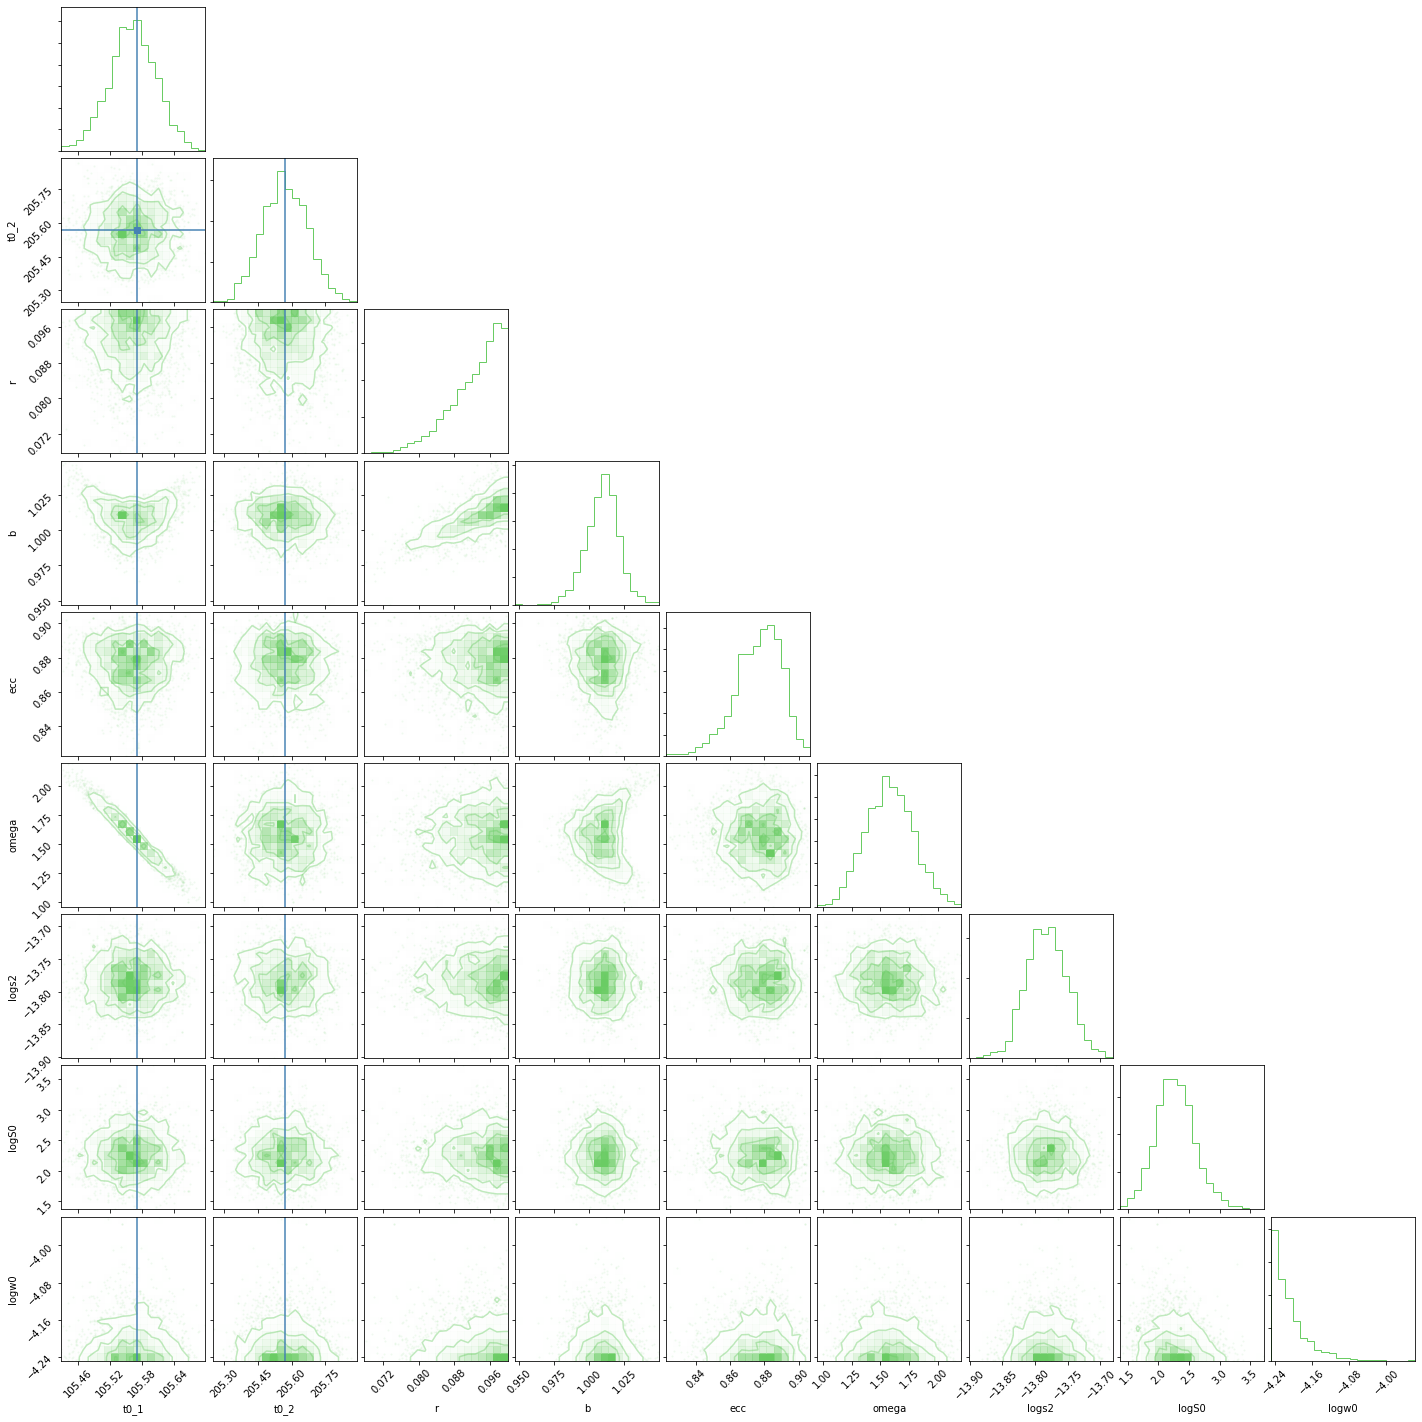

In [74]:
corner.corner(pm.trace_to_dataframe(trace, varnames=["t0_1", "t0_2", "r", "b","ecc","omega","logs2","logS0","logw0"]),
                         labels=["t0_1", "t0_2", "r", "b","ecc","omega","logs2","logS0","logw0"], 
                         truths=np.concatenate((t0s, [np.sqrt(0.00325), 0.3, 0.025, 0.7,np.log(0.001),np.log(0.001),np.log(0.001)])),
                         color=sns.color_palette()[2])
#true_orbit = xo.orbits.KeplerianOrbit(period=100/3.0, t0=t0s[0], b=0.3, omega=0.72, ecc=0.025)


In [63]:
np.exp(-13.7)

1.1224463652343442e-06

In [64]:
np.log(np.std(y))

-6.4127114051370215

(100, 112)

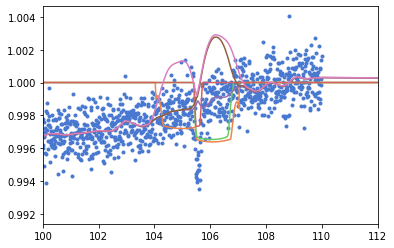

In [67]:
plt.plot(x,y,'.')
plt.plot(x,1.0+np.percentile(trace['light_curve'],10,axis=0))
plt.plot(x,1.0+np.percentile(trace['light_curve'],50,axis=0))
plt.plot(x,1.0+np.percentile(trace['light_curve'],90,axis=0))
plt.plot(x,np.percentile(trace['gp_pred'],10,axis=0))
plt.plot(x,np.percentile(trace['gp_pred'],50,axis=0))
plt.plot(x,np.percentile(trace['gp_pred'],90,axis=0))
plt.xlim(100,112)

In [81]:
models={}
optimized={}
traces={}
samples={}
figures={}

optimizing logp for variables: [b, r]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-1.372364e+04]
1it [00:00, 188.96it/s, logp=-1.372364e+04]
2it [00:00, 266.70it/s, logp=-1.372364e+04]
3it [00:00, 303.12it/s, logp=-1.369773e+04]
4it [00:00, 319.21it/s, logp=-1.369316e+04]
5it [00:00, 331.57it/s, logp=-1.369149e+04]
6it [00:00, 341.86it/s, logp=-1.368929e+04]
7it [00:00, 349.89it/s, logp=-1.368945e+04]
8it [00:00, 348.28it/s, logp=-1.368915e+04]
9it [00:00, 344.90it/s, logp=-1.368891e+04]
10it [00:00, 343.58it/s, logp=-1.368888e+04]
11it [00:00, 333.57it/s, logp=-1.368918e+04]
12it [00:00, 334.35it/s, logp=-1.368886e+04]
13it [00:00, 335.82it/s, logp=-1.368885e+04]
14it [00:00, 337.65it/s, logp=-1.368893e+04]
15it [00:00, 337.09it/s, logp=-1.368884e+04]
16it [00:00, 335.71it/s, logp=-1.368883e+04]
17it [00:00, 333.93it/s, logp=-1.368889e+04]
18it [00:00, 331.56it/s, logp=-1.368883e+04]
19it [00:00, 329.97it/s, logp=-1.368883e+04]
20it [00:00, 327.30it/s, logp=-1.368883e+04]
21it [00:00,

13it [00:00, 256.28it/s, logp=9.290448e+03]
14it [00:00, 255.06it/s, logp=9.412087e+03]
15it [00:00, 256.07it/s, logp=9.479490e+03]
16it [00:00, 246.51it/s, logp=9.515337e+03]
17it [00:00, 247.00it/s, logp=9.533708e+03]
18it [00:00, 246.51it/s, logp=9.542789e+03]
19it [00:00, 248.19it/s, logp=9.547079e+03]
20it [00:00, 249.95it/s, logp=9.548961e+03]
21it [00:00, 250.79it/s, logp=9.549680e+03]
22it [00:00, 248.98it/s, logp=9.549891e+03]
23it [00:00, 249.96it/s, logp=9.549929e+03]
24it [00:00, 250.03it/s, logp=9.549932e+03]
25it [00:00, 251.37it/s, logp=9.549932e+03]
26it [00:00, 258.48it/s, logp=9.549932e+03]
27it [00:01, 26.68it/s, logp=9.549932e+03] 
message: Optimization terminated successfully.
logp: -13484.058396779847 -> 9549.931786273022
optimizing logp for variables: [logw0]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=9.549932e+03]
1it [00:00, 118.17it/s, logp=9.549932e+03]
2it [00:00, 152.78it/s, logp=9.549932e+03]
3it [00:00, 165.67it/s, logp=1.069228e+04]
4it [00:00, 183.45it

104it [00:00, 137.90it/s, logp=1.076103e+04]
105it [00:00, 137.90it/s, logp=1.076103e+04]
106it [00:00, 137.90it/s, logp=1.076103e+04]
107it [00:00, 137.90it/s, logp=1.076103e+04]
108it [00:00, 137.90it/s, logp=1.076103e+04]
109it [00:00, 137.90it/s, logp=1.076103e+04]
110it [00:00, 137.90it/s, logp=1.076103e+04]
111it [00:00, 139.98it/s, logp=1.076103e+04]
111it [00:00, 139.98it/s, logp=1.076103e+04]
112it [00:00, 139.98it/s, logp=1.076103e+04]
113it [00:00, 139.98it/s, logp=1.076103e+04]
114it [00:00, 139.98it/s, logp=1.076103e+04]
115it [00:00, 139.98it/s, logp=1.076103e+04]/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
116it [00:02, 54.88it/s, logp=1.07

Sampling 4 chains, 0 divergences:   5%|▌         | 381/7200 [00:36<09:53, 11.48draws/s]


Sampling 4 chains, 0 divergences:   9%|▉         | 637/7200 [00:51<05:43, 19.11draws/s]


Sampling 4 chains, 0 divergences:  14%|█▍        | 1012/7200 [01:04<03:03, 33.74draws/s]


Sampling 4 chains, 0 divergences:  20%|██        | 1449/7200 [01:17<02:48, 34.19draws/s]


Sampling 4 chains, 4 divergences:  27%|██▋       | 1963/7200 [01:27<01:22, 63.82draws/s]


Sampling 4 chains, 9 divergences:  35%|███▍      | 2495/7200 [01:41<31:17,  2.51draws/s]


Sampling 4 chains, 9 divergences:  36%|███▌      | 2597/7200 [02:30<35:32,  2.16draws/s]


Sampling 4 chains, 9 divergences:  38%|███▊      | 2702/7200 [03:18<45:39,  1.64draws/s]


Sampling 4 chains, 9 divergences:  39%|███▉      | 2799/7200 [04:01<34:24,  2.13draws/s]


Sampling 4 chains, 9 divergences:  40%|████      | 2901/7200 [04:48<33:44,  2.12draws/s]


Sampling 4 chains, 9 divergences:  42%|████▏     | 3005/7200 [05:34<40:27,  1.73draws/s]


Sampling 4 chains, 9 divergences:  43%|████▎     | 3114/7200 [06:24<30:56,  2.20draws/s]


Sampling 4 chains, 9 divergences:  45%|████▍     | 3207/7200 [07:10<52:11,  1.28draws/s]


Sampling 4 chains, 9 divergences:  46%|████▌     | 3309/7200 [08:01<27:54,  2.32draws/s]


Sampling 4 chains, 9 divergences:  47%|████▋     | 3414/7200 [08:47<25:30,  2.47draws/s]


Sampling 4 chains, 9 divergences:  49%|████▉     | 3517/7200 [09:34<21:48,  2.82draws/s]


Sampling 4 chains, 9 divergences:  50%|█████     | 3622/7200 [10:24<28:55,  2.06draws/s]


Sampling 4 chains, 9 divergences:  52%|█████▏    | 3720/7200 [11:09<29:37,  1.96draws/s]


Sampling 4 chains, 9 divergences:  53%|█████▎    | 3826/7200 [12:08<36:13,  1.55draws/s]


Sampling 4 chains, 9 divergences:  54%|█████▍    | 3917/7200 [12:59<27:50,  1.97draws/s]


Sampling 4 chains, 9 divergences:  56%|█████▌    | 4016/7200 [13:50<34:05,  1.56draws/s]


Sampling 4 chains, 9 divergences:  57%|█████▋    | 4123/7200 [14:45<29:49,  1.72draws/s]


Sampling 4 chains, 9 divergences:  59%|█████▊    | 4221/7200 [15:43<33:48,  1.47draws/s]


Sampling 4 chains, 9 divergences:  60%|██████    | 4327/7200 [16:42<30:09,  1.59draws/s]


Sampling 4 chains, 9 divergences:  62%|██████▏   | 4434/7200 [17:43<22:18,  2.07draws/s]


Sampling 4 chains, 9 divergences:  63%|██████▎   | 4537/7200 [18:44<32:20,  1.37draws/s]


Sampling 4 chains, 9 divergences:  64%|██████▍   | 4634/7200 [19:39<17:24,  2.46draws/s]


Sampling 4 chains, 9 divergences:  66%|██████▌   | 4750/7200 [20:33<23:35,  1.73draws/s]


Sampling 4 chains, 9 divergences:  67%|██████▋   | 4855/7200 [21:32<29:47,  1.31draws/s]


Sampling 4 chains, 9 divergences:  69%|██████▊   | 4945/7200 [22:22<18:37,  2.02draws/s]


Sampling 4 chains, 9 divergences:  70%|███████   | 5052/7200 [23:25<20:26,  1.75draws/s]


Sampling 4 chains, 9 divergences:  71%|███████▏  | 5142/7200 [24:28<28:50,  1.19draws/s]


Sampling 4 chains, 9 divergences:  73%|███████▎  | 5261/7200 [25:41<22:43,  1.42draws/s]


Sampling 4 chains, 9 divergences:  74%|███████▍  | 5364/7200 [26:57<23:35,  1.30draws/s]


Sampling 4 chains, 9 divergences:  76%|███████▌  | 5460/7200 [28:00<14:57,  1.94draws/s]


Sampling 4 chains, 9 divergences:  77%|███████▋  | 5549/7200 [28:46<13:03,  2.11draws/s]


Sampling 4 chains, 9 divergences:  79%|███████▊  | 5659/7200 [29:41<15:15,  1.68draws/s]


Sampling 4 chains, 9 divergences:  80%|███████▉  | 5750/7200 [30:28<11:55,  2.03draws/s]


Sampling 4 chains, 9 divergences:  82%|████████▏ | 5877/7200 [31:29<10:22,  2.12draws/s]


Sampling 4 chains, 9 divergences:  83%|████████▎ | 5970/7200 [32:11<09:57,  2.06draws/s]


Sampling 4 chains, 9 divergences:  84%|████████▍ | 6076/7200 [32:58<06:23,  2.93draws/s]


Sampling 4 chains, 9 divergences:  86%|████████▌ | 6181/7200 [33:44<07:32,  2.25draws/s]


Sampling 4 chains, 9 divergences:  87%|████████▋ | 6279/7200 [34:29<07:05,  2.16draws/s]


Sampling 4 chains, 9 divergences:  89%|████████▊ | 6382/7200 [35:20<06:21,  2.14draws/s]


Sampling 4 chains, 9 divergences:  90%|█████████ | 6480/7200 [36:07<05:18,  2.26draws/s]


Sampling 4 chains, 9 divergences:  92%|█████████▏| 6591/7200 [37:01<04:26,  2.28draws/s]


Sampling 4 chains, 9 divergences:  93%|█████████▎| 6691/7200 [37:48<04:04,  2.08draws/s]


Sampling 4 chains, 9 divergences:  94%|█████████▍| 6793/7200 [38:37<05:23,  1.26draws/s]


Sampling 4 chains, 9 divergences:  96%|█████████▌| 6908/7200 [39:30<02:28,  1.97draws/s]


Sampling 4 chains, 9 divergences:  97%|█████████▋| 7009/7200 [40:14<01:37,  1.96draws/s]


Sampling 4 chains, 9 divergences:  99%|█████████▊| 7109/7200 [41:17<02:03,  1.36s/draws]


Sampling 4 chains, 9 divergences: 100%|█████████▉| 7196/7200 [1:53:47<00:07,  1.85s/draws]


Sampling 4 chains, 9 divergences: 100%|██████████| 7200/7200 [1:53:55<00:00,  1.05draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
/Library/Python/3.7/site-packages/thean

78it [00:04, 16.14it/s, logp=-1.342186e+04] 
message: Desired error not necessarily achieved due to precision loss.
logp: -13422.433523584623 -> -13421.85541121401
optimizing logp for variables: [omega, ecc]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-1.342186e+04]
1it [00:00, 154.83it/s, logp=-1.342186e+04]
2it [00:00, 224.52it/s, logp=-1.342186e+04]
3it [00:00, 230.52it/s, logp=-1.344451e+04]
4it [00:00, 236.39it/s, logp=-1.341710e+04]
5it [00:00, 250.79it/s, logp=-1.341003e+04]
6it [00:00, 261.87it/s, logp=-1.344227e+04]
7it [00:00, 275.27it/s, logp=-1.340866e+04]
8it [00:00, 273.45it/s, logp=-1.340620e+04]
9it [00:00, 273.00it/s, logp=-1.340243e+04]
10it [00:00, 277.12it/s, logp=-1.339829e+04]
11it [00:00, 282.27it/s, logp=-1.339750e+04]
12it [00:00, 285.31it/s, logp=-1.339756e+04]
13it [00:00, 287.10it/s, logp=-1.339743e+04]
14it [00:00, 284.48it/s, logp=-1.339740e+04]
15it [00:00, 288.53it/s, logp=-1.339739e+04]
16it [00:00, 291.67it/s, logp=-1.339739e+04]
17it [00:00, 296.44it/

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logpower, logw0, logs2, omega, ecc, b, r, u, logrho_S, Rs, t0_2, t0_1]
INFO:pymc3:NUTS: [logpower, logw0, logs2, omega, ecc, b, r, u, logrho_S, Rs, t0_2, t0_1]

Sampling 4 chains, 0 divergences:   3%|▎         | 186/7200 [00:15<09:33, 12.24draws/s]


Sampling 4 chains, 0 divergences:   7%|▋         | 475/7200 [00:38<04:09, 26.96draws/s]


Sampling 4 chains, 0 divergences:  17%|█▋        | 1194/7200 [00:49<01:21, 74.06draws/s]


Sampling 4 chains, 0 divergences:  26%|██▌       | 1878/7200 [00:59<01:10, 75.02draws/s]


Sampling 4 chains, 0 divergences:  36%|███▌      | 2557/7200 [01:10<01:10, 65.51draws/s]


Sampling 4 chains, 0 divergences:  45%|████▍     | 3208/7200 [01:20<01:07, 58.73draws/s]


Sampling 4 chains, 0 divergences:  54%|█████▍    | 3897/7200 [01:31<00:48, 68.45draws/s]


Sampling 4 chains, 0 divergences:  64%|██████▍   | 4606/7200 [01:41<00:36, 70.33draws/s]


Sampling 4 chains, 0 divergences:  74%|███████▍  | 5325/7200 [01:52<00:27, 68.82draws/s]


Sampling 4 chains, 0 divergences:  84%|████████▍ | 6048/7200 [02:02<00:16, 71.62draws/s]


Sampling 4 chains, 0 divergences:  94%|█████████▍| 6761/7200 [02:13<00:08, 52.72draws/s]


Sampling 4 chains, 0 divergences: 100%|██████████| 7200/7200 [02:24<00:00, 49.87draws/s]
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.
/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


optimizing logp for variables: [b, r]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-1.367022e+04]
1it [00:00, 254.97it/s, logp=-1.367022e+04]
2it [00:00, 319.43it/s, logp=-1.367022e+04]
3it [00:00, 344.24it/s, logp=-1.367118e+04]
4it [00:00, 344.38it/s, logp=-1.366722e+04]
5it [00:00, 334.99it/s, logp=-1.366721e+04]
6it [00:00, 339.25it/s, logp=-1.366721e+04]
7it [00:00, 344.67it/s, logp=-1.366721e+04]
8it [00:00, 350.62it/s, logp=-1.366721e+04]
9it [00:00, 354.79it/s, logp=-1.366721e+04]
11it [00:01, 10.73it/s, logp=-1.366721e+04] 
message: Optimization terminated successfully.
logp: -13670.216888457056 -> -13667.209130916079
optimizing logp for variables: [logs2]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-1.366721e+04]
1it [00:00, 230.10it/s, logp=-1.366721e+04]
2it [00:00, 293.90it/s, logp=-1.366721e+04]
3it [00:00, 302.95it/s, logp=-1.349298e+04]
4it [00:00, 308.88it/s, logp=-1.347590e+04]
5it [00:00, 320.74it/s, logp=-1.347223e+04]
6it [00:00, 332.74it/s, logp=-1.347218e+04]
7it 

58it [00:00, 327.79it/s, logp=1.072100e+04]
59it [00:00, 327.79it/s, logp=1.072100e+04]
60it [00:00, 304.66it/s, logp=1.072100e+04]
60it [00:00, 304.66it/s, logp=1.072100e+04]
61it [00:00, 304.66it/s, logp=1.072100e+04]
62it [00:00, 304.66it/s, logp=1.072100e+04]
63it [00:00, 304.66it/s, logp=1.072100e+04]
64it [00:00, 304.66it/s, logp=1.072100e+04]
65it [00:00, 304.66it/s, logp=1.072100e+04]
66it [00:00, 304.66it/s, logp=1.072100e+04]
67it [00:00, 304.66it/s, logp=1.072100e+04]
68it [00:00, 304.66it/s, logp=1.072100e+04]
69it [00:00, 304.66it/s, logp=1.072100e+04]/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
70it [00:01, 53.87it/s, logp=1.072100e+04] 
mes

103it [00:00, 196.42it/s, logp=1.091716e+04]
104it [00:00, 196.42it/s, logp=1.091716e+04]
105it [00:00, 196.42it/s, logp=1.091716e+04]
106it [00:00, 210.52it/s, logp=1.091716e+04]
106it [00:00, 210.52it/s, logp=1.091716e+04]
107it [00:00, 210.52it/s, logp=1.091716e+04]
108it [00:00, 210.52it/s, logp=1.091716e+04]
109it [00:00, 210.52it/s, logp=1.091716e+04]
110it [00:00, 210.52it/s, logp=1.091716e+04]
111it [00:00, 210.52it/s, logp=1.091716e+04]
112it [00:00, 210.52it/s, logp=1.091716e+04]
113it [00:00, 210.52it/s, logp=1.091716e+04]
114it [00:00, 210.52it/s, logp=1.091716e+04]
115it [00:00, 210.52it/s, logp=1.091716e+04]
116it [00:00, 210.52it/s, logp=1.091716e+04]
117it [00:00, 210.52it/s, logp=1.091716e+04]
118it [00:00, 210.52it/s, logp=1.091716e+04]
119it [00:00, 210.52it/s, logp=1.091716e+04]
120it [00:00, 210.52it/s, logp=1.091716e+04]
121it [00:00, 210.52it/s, logp=1.091716e+04]
122it [00:00, 210.52it/s, logp=1.091716e+04]
123it [00:00, 210.52it/s, logp=1.091716e+04]
124it [00:

Sampling 4 chains, 0 divergences:   5%|▍         | 342/7200 [00:28<09:17, 12.31draws/s]


Sampling 4 chains, 0 divergences:  11%|█         | 777/7200 [00:42<01:15, 85.09draws/s]


Sampling 4 chains, 0 divergences:  21%|██        | 1491/7200 [00:53<01:28, 64.31draws/s]


Sampling 4 chains, 0 divergences:  30%|███       | 2172/7200 [01:04<01:22, 60.72draws/s]


Sampling 4 chains, 0 divergences:  39%|███▉      | 2842/7200 [01:15<01:10, 61.95draws/s]


Sampling 4 chains, 0 divergences:  48%|████▊     | 3489/7200 [01:26<01:05, 56.58draws/s]


Sampling 4 chains, 0 divergences:  58%|█████▊    | 4180/7200 [01:36<00:54, 55.48draws/s]


Sampling 4 chains, 0 divergences:  67%|██████▋   | 4806/7200 [01:47<00:33, 70.57draws/s]


Sampling 4 chains, 0 divergences:  76%|███████▌  | 5440/7200 [01:58<00:29, 60.35draws/s]


Sampling 4 chains, 0 divergences:  85%|████████▍ | 6094/7200 [02:08<00:19, 56.89draws/s]


Sampling 4 chains, 0 divergences:  92%|█████████▏| 6650/7200 [02:19<00:12, 45.60draws/s]


Sampling 4 chains, 0 divergences:  98%|█████████▊| 7079/7200 [02:31<00:04, 30.18draws/s]


Sampling 4 chains, 0 divergences: 100%|██████████| 7200/7200 [02:37<00:00, 45.80draws/s]
/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [b, r]

0it [00:00, ?it/s]
0it [00:00, ?it/s, logp=-1.367436e+04]
1it [00:00, 253.68it/s, logp=-1.367436e+04]
2it [00:00, 293.09it/s, logp=-1.367436e+04]
3it [00:00, 287.27it/s, logp=-1.367367e+04]
4it [00:00, 306.54it/s, logp=-1.367240e+04]
5it [00:00, 318.15it/s, logp=-1.367092e+04]
6it [00:00, 323.59it/s, logp=-1.367090e+04]
7it [00:00, 332.27it/s, logp=-1.367090e+04]
8it [00:00, 339.44it/s, logp=-1.367089e+04]
9it [00:00, 334.60it/s, logp=-1.367089e+04]
10it [00:00, 330.86it/s, logp=-1.367

54it [00:00, 335.76it/s, logp=-1.347883e+04]
55it [00:00, 335.76it/s, logp=-1.347883e+04]
56it [00:00, 335.76it/s, logp=-1.347883e+04]
57it [00:00, 289.12it/s, logp=-1.347883e+04]
57it [00:00, 289.12it/s, logp=-1.347883e+04]
58it [00:00, 289.12it/s, logp=-1.347883e+04]
59it [00:00, 289.12it/s, logp=-1.347883e+04]
60it [00:00, 289.12it/s, logp=-1.347883e+04]
61it [00:00, 289.12it/s, logp=-1.347883e+04]/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])

62it [00:00, 289.12it/s, logp=-1.347883e+04]
63it [00:00, 289.12it/s, logp=-1.347883e+04]
64it [00:00, 289.12it/s, logp=-1.347883e+04]
65it [00:00, 289.12it/s, logp=-1.347883e+04]
66it [00:00, 289.12it/s, logp=-1.

73it [00:00, 298.26it/s, logp=1.067970e+04]
74it [00:00, 298.26it/s, logp=1.067970e+04]
75it [00:00, 298.26it/s, logp=1.067970e+04]
76it [00:00, 298.26it/s, logp=1.067970e+04]
77it [00:00, 298.26it/s, logp=1.067970e+04]
78it [00:00, 298.26it/s, logp=1.067970e+04]
79it [00:00, 298.26it/s, logp=1.067970e+04]
80it [00:00, 298.26it/s, logp=1.067970e+04]
81it [00:00, 298.26it/s, logp=1.067970e+04]
82it [00:00, 298.26it/s, logp=1.067970e+04]
83it [00:00, 298.26it/s, logp=1.067970e+04]
84it [00:00, 298.26it/s, logp=1.067970e+04]
85it [00:00, 298.26it/s, logp=1.067970e+04]
86it [00:00, 298.26it/s, logp=1.067970e+04]/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])

87

81it [00:00, 249.59it/s, logp=1.085603e+04]
82it [00:00, 249.59it/s, logp=1.085859e+04]
83it [00:00, 249.59it/s, logp=1.085860e+04]
84it [00:00, 249.59it/s, logp=-5.223676e+08]
85it [00:00, 249.59it/s, logp=1.085860e+04] 
86it [00:00, 249.59it/s, logp=1.085860e+04]
87it [00:00, 249.59it/s, logp=-5.223676e+08]
88it [00:00, 249.59it/s, logp=-6.786616e+08]
89it [00:00, 249.59it/s, logp=-2.991650e+07]
90it [00:00, 249.59it/s, logp=9.961397e+03] /Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])

91it [00:00, 249.59it/s, logp=1.055781e+04]
92it [00:00, 249.59it/s, logp=1.076748e+04]
93it [00:00, 212.05it/s, logp=1.076748e+04]
93it [00:00, 212.05it/s, logp=1.084178e+

222it [00:01, 221.11it/s, logp=1.091667e+04]
223it [00:01, 221.11it/s, logp=1.091667e+04]
224it [00:01, 221.11it/s, logp=1.091667e+04]
225it [00:01, 221.11it/s, logp=1.091667e+04]
226it [00:01, 221.11it/s, logp=1.091667e+04]
227it [00:01, 221.11it/s, logp=1.091667e+04]
228it [00:01, 221.11it/s, logp=1.091667e+04]/Library/Python/3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
229it [00:02, 113.37it/s, logp=1.091667e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: 10693.68384382157 -> 10916.67061048805
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logpower, logw0, logs2, omega, ecc, b, 

Sampling 4 chains, 0 divergences:   6%|▌         | 422/7200 [00:39<11:07, 10.15draws/s]


Sampling 4 chains, 0 divergences:  14%|█▍        | 1024/7200 [00:51<01:28, 69.77draws/s]


Sampling 4 chains, 0 divergences:  23%|██▎       | 1676/7200 [01:01<01:54, 48.04draws/s]


Sampling 4 chains, 0 divergences:  33%|███▎      | 2341/7200 [01:12<01:17, 63.10draws/s]


Sampling 4 chains, 0 divergences:  42%|████▏     | 3025/7200 [01:23<01:04, 64.81draws/s]


Sampling 4 chains, 0 divergences:  51%|█████▏    | 3695/7200 [01:33<00:57, 61.13draws/s]


Sampling 4 chains, 0 divergences:  60%|█████▉    | 4286/7200 [01:45<01:04, 44.95draws/s]


Sampling 4 chains, 0 divergences:  68%|██████▊   | 4921/7200 [01:55<00:34, 66.33draws/s]


Sampling 4 chains, 0 divergences:  77%|███████▋  | 5556/7200 [02:06<00:26, 61.75draws/s]


Sampling 4 chains, 0 divergences:  86%|████████▌ | 6180/7200 [02:17<00:20, 49.44draws/s]


Sampling 4 chains, 0 divergences:  95%|█████████▍| 6810/7200 [02:28<00:10, 38.18draws/s]


Sampling 4 chains, 0 divergences: 100%|██████████| 7200/7200 [02:40<00:00, 45.00draws/s]
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


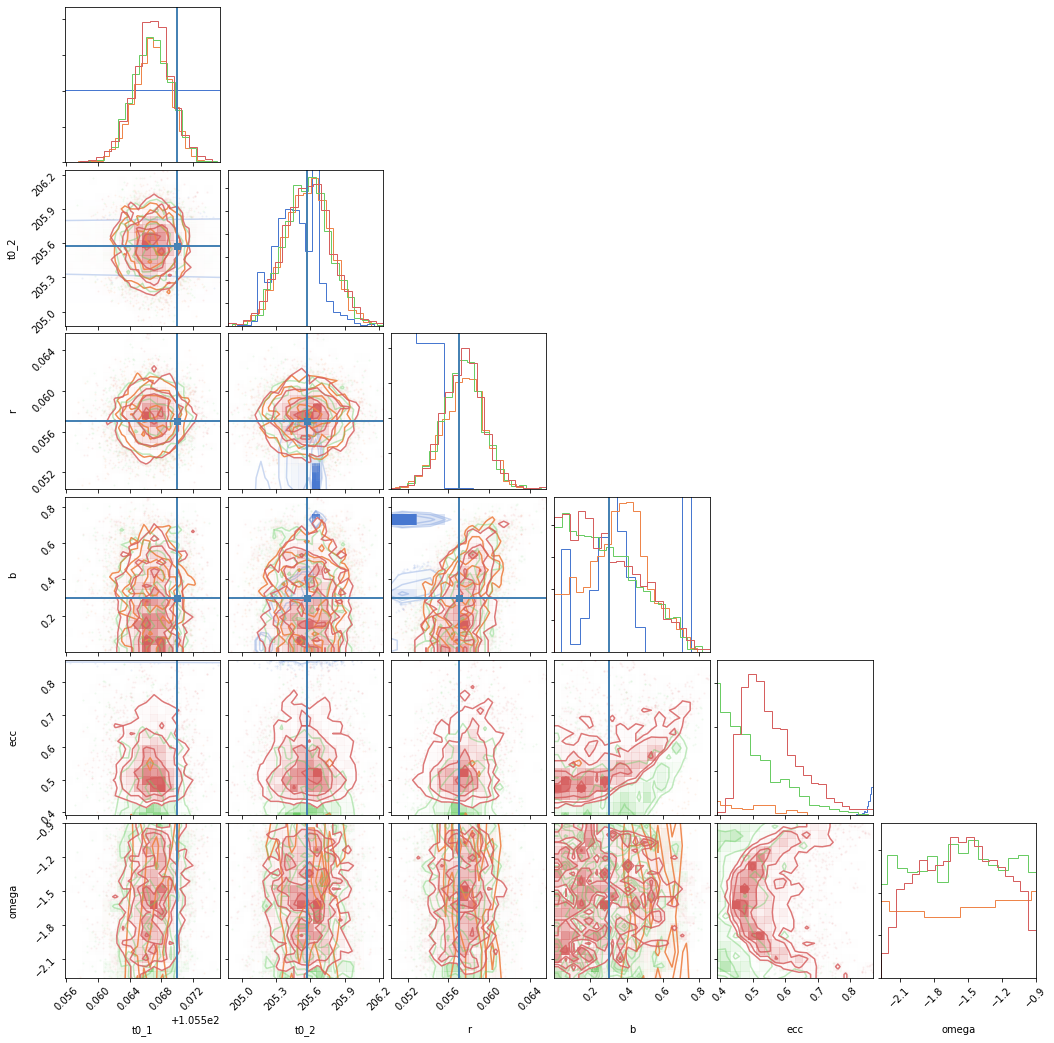

In [83]:
fig,ax=plt.subplots(6,6,figsize=(15,15))
for ni,per in enumerate([100,33.3333333,10,5.88235294]):
    if ni not in figures:
        with pm.Model() as model:

                # The time of a reference time for each transit
                t0_1 = pm.Normal("t0_1", mu=t0s[0], sd=0.2)
                t0_2 = pm.Normal("t0_2", mu=t0s[1], sd=0.2)

                #Stellar stuff
                Rs = pm.Normal("Rs", mu=1.0, sd=0.3)
                logrho_S = pm.Normal("logrho_S", mu=0.0, sd=0.5)
                rho_S = pm.Deterministic("rho_S",tt.exp(logrho_S))

                # The Kipping (2013) parameterization for quadratic limb darkening paramters
                u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))

                r = pm.Uniform("r", lower=0.01, upper=0.1,  testval=np.sqrt(0.00325))
                b = xo.distributions.ImpactParameter("b", ror=r, testval=0.41)

                periods = pm.Deterministic("periods", (t0_2 - t0_1) / period_index)

                #Initialising eccentricity and omega:
                BoundedBeta = pm.Bound(pm.Beta, lower=1e-5, upper=1-1e-5)
                ecc = BoundedBeta("ecc", alpha=0.867, beta=3.03)
                omega = xo.distributions.Angle("omega")
                period = per

                #Jitter term. Initialised with the std of y
                logs2 = pm.Normal("logs2", mu=np.log(np.var(y)),sd=1.0,testval=np.log(np.var(y)))

                #Guess P_var=10d to begin:
                logw0_guess = np.log(2*np.pi/10)

                #freq bounded from 2pi/minimum_cadence to to 2pi/(4x lc length)
                min_cad=np.nanmedian(np.diff(x))#Limiting to <1 cadence
                lcrange=x[-1]-x[0]
                logw0 = pm.Uniform("logw0",lower=np.log((2*np.pi)/(4*lcrange)), 
                                   upper=np.log((2*np.pi)/min_cad),testval=logw0_guess)

                # S_0 directly because this removes some of the degeneracies between
                # S_0 and omega_0 prior=(-0.25*lclen)*exp(logS0)
                logpower = pm.Uniform("logpower",lower=-20,upper=np.log(np.nanmedian(abs(np.diff(y)))),testval=-10)
                logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

                # Initialising GP model for the light curve
                kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
                gp = xo.gp.GP(kernel, x, tt.exp(logs2) + tt.zeros(len(x)), J=2)

                # Set up a Keplerian orbit for the planets
                orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0_1, b=b,
                                                 ecc=ecc,omega=omega)

                light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=x)
                light_curve = pm.Deterministic("light_curve", pm.math.sum(light_curves, axis=-1))

                llk_gp = pm.Potential("transit_obs", gp.log_likelihood(y - light_curve))
                gp_pred = pm.Deterministic("gp_pred", gp.predict())

                map_soln_gp_marg_ecc = xo.optimize(vars=[r, b])
                map_soln_gp_marg_ecc = xo.optimize(start=map_soln_gp_marg_ecc, vars=[logs2])
                map_soln_gp_marg_ecc = xo.optimize(start=map_soln_gp_marg_ecc, vars=[t0_1, t0_2])
                map_soln_gp_marg_ecc = xo.optimize(start=map_soln_gp_marg_ecc, vars=[ecc, omega])
                map_soln_gp_marg_ecc = xo.optimize(start=map_soln_gp_marg_ecc, vars=[logs2, logpower])
                map_soln_gp_marg_ecc = xo.optimize(start=map_soln_gp_marg_ecc, vars=[logw0])
                map_soln_gp_marg_ecc = xo.optimize(start=map_soln_gp_marg_ecc, vars=[r,b,ecc,Rs,u])
                map_soln = xo.optimize(map_soln_gp_marg_ecc)

        models[ni]=model
        optimized[ni]=map_soln

        np.random.seed(42)
        with models[ni]:
            trace = pm.sample(
                tune=1200,
                draws=600,
                start=optimized[ni],
                chains=4,
                step=xo.get_dense_nuts_step(target_accept=0.9),
            )
        traces[ni]=trace
        samples[ni] = pm.trace_to_dataframe(traces[ni], varnames=["t0_1", "t0_2", "r", "b","ecc","omega"])
        figures[ni]=corner.corner(samples[ni], 
                                 labels=["t0_1", "t0_2", "r", "b","ecc","omega"], 
                                 truths=np.concatenate((t0s, [np.sqrt(0.00325), 0.3, 0.025, 0.72])),
                                 fig=fig,color=sns.color_palette()[ni])
        pickle.dump([models,optimized,traces,samples,figures],open("marg_all_data.pickle","wb"))

In [104]:
periods

periods

In [110]:
dis_per

array([100.        ,  50.        ,  33.33333333,  25.        ,
        20.        ,  16.66666667,  14.28571429,  12.5       ,
        11.11111111,  10.        ,   9.09090909,   8.33333333,
         7.69230769,   7.14285714,   6.66666667,   6.25      ,
         5.88235294])

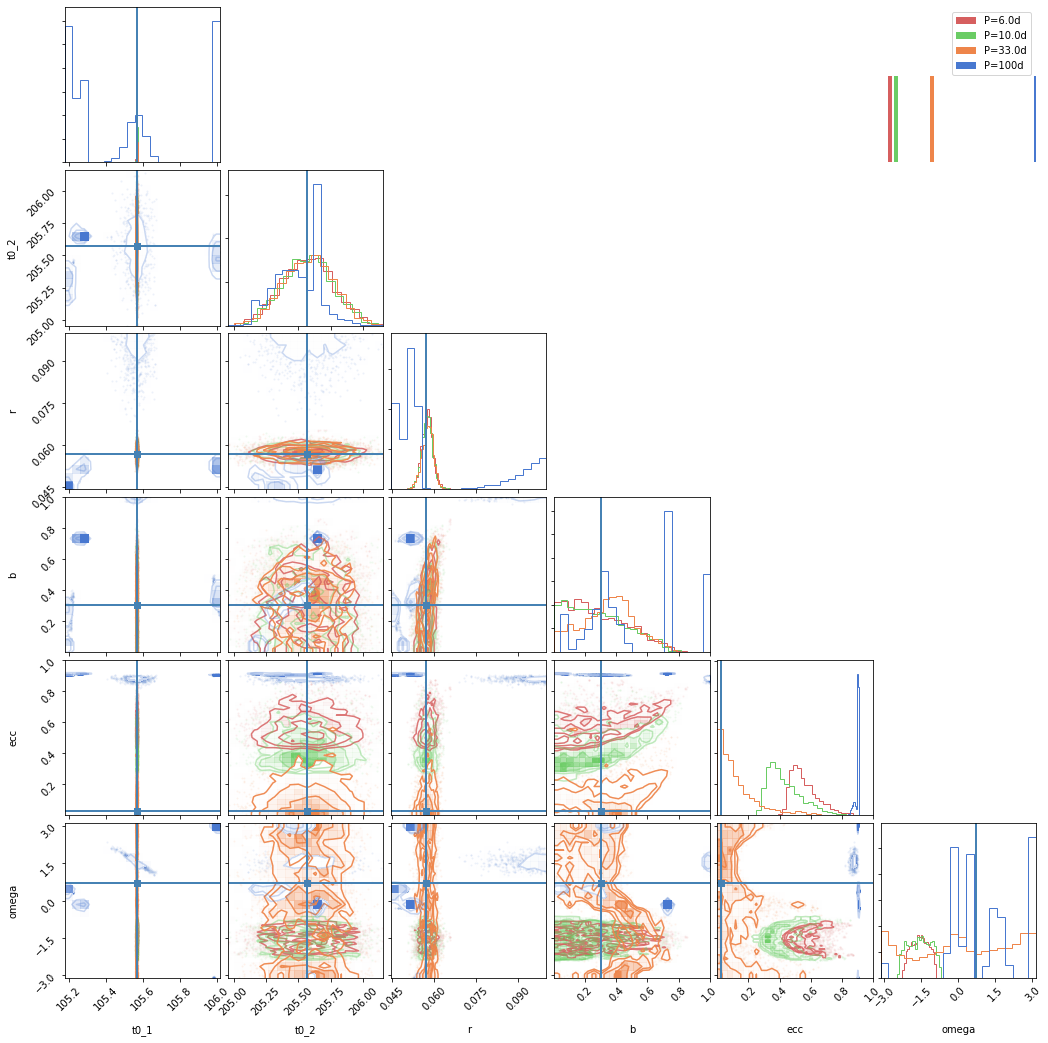

In [116]:
fig,ax=plt.subplots(6,6,figsize=(15,15))

for ni2 in [3,2,1,0]:
    corner.corner(samples[ni2], 
                 labels=["t0_1", "t0_2", "r", "b","ecc","omega"], 
                 truths=np.concatenate((t0s, [np.sqrt(0.00325), 0.3, 0.025, 0.72])),
                 fig=fig,color=sns.color_palette()[ni2])
for ny,y_ax in enumerate(ax):
    for nx,x_ax in enumerate(y_ax):
        if nx in [3,4]:
            x_ax.set_xlim(0,1.0)
        elif nx==5:
            x_ax.set_xlim(-np.pi,np.pi)
        if ny in [3,4] and nx!=ny:
            x_ax.set_ylim(0,1.0)
        elif ny==5 and nx!=ny:
            x_ax.set_ylim(-np.pi,np.pi)

dis_per=(t0s[1]-t0s[0]) / period_index
pers=[100,100/3,100/10,100/17]
for ni in [3,2,1,0]:
    ax[0][5].bar(dis_per,(dis_per==pers[ni]).astype(int),label='P='+str(np.round(pers[ni]))+'d',width=2.5,color=sns.color_palette()[ni])
#ax[0][5].bar(dis_per,(dis_per==100/3).astype(int),label='P=33d',width=4,color=sns.color_palette()[2])
#ax[0][5].bar(dis_per,(dis_per==10).astype(int),label='P=10d',width=4,color=sns.color_palette()[1])
ax[0][5].legend()
ax[0][5].set_xlim(0,100)
ax[0][5].set_ylim(0,1.8)

plt.savefig("Seperate_MCMC_corners.png",dpi=200)

In [92]:
samples.keys()

dict_keys([0, 1, 2, 3])

In [89]:
len(ax[0])

6

In [84]:
corner.corner

<function corner.corner.corner(xs, bins=20, range=None, weights=None, color='k', smooth=None, smooth1d=None, labels=None, label_kwargs=None, show_titles=False, title_fmt='.2f', title_kwargs=None, truths=None, truth_color='#4682b4', scale_hist=False, quantiles=None, verbose=False, fig=None, max_n_ticks=5, top_ticks=False, use_math_text=False, hist_kwargs=None, **hist2d_kwargs)>

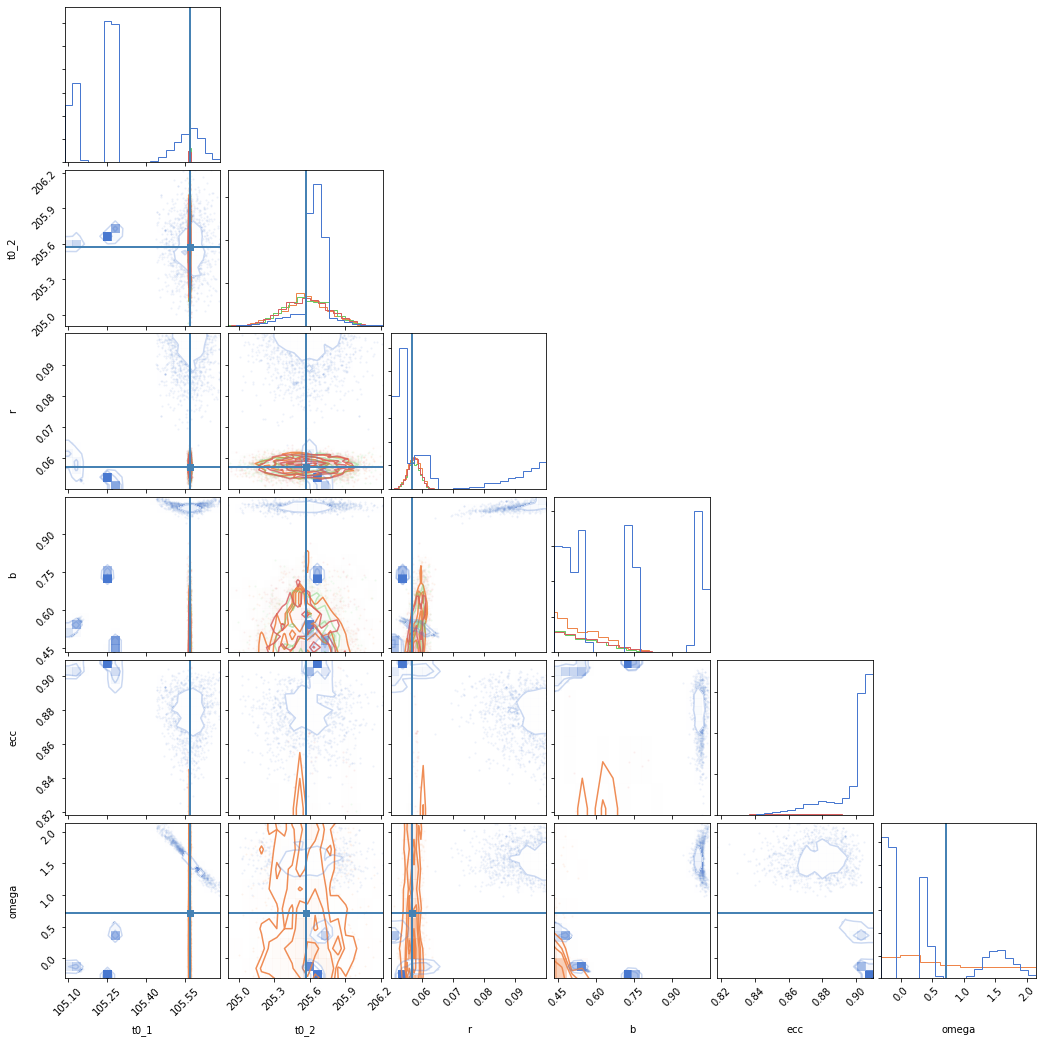

In [32]:
fig,ax=plt.subplots(6,6,figsize=(15,15))

for ni in [1,2,3,0]:
    newfig=corner.corner(samples[ni], 
                 labels=["t0_1", "t0_2", "r", "b","ecc","omega"], 
                 truths=np.concatenate((t0s, [np.sqrt(0.00325), 0.3, 0.025, 0.72])),
                 fig=fig,color=sns.color_palette()[ni])

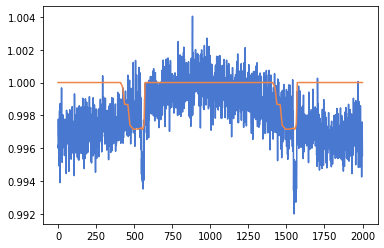

In [39]:
plt.plot(y)
plt.plot(1.0+np.nanmedian(traces[0]['light_curve'],axis=0))


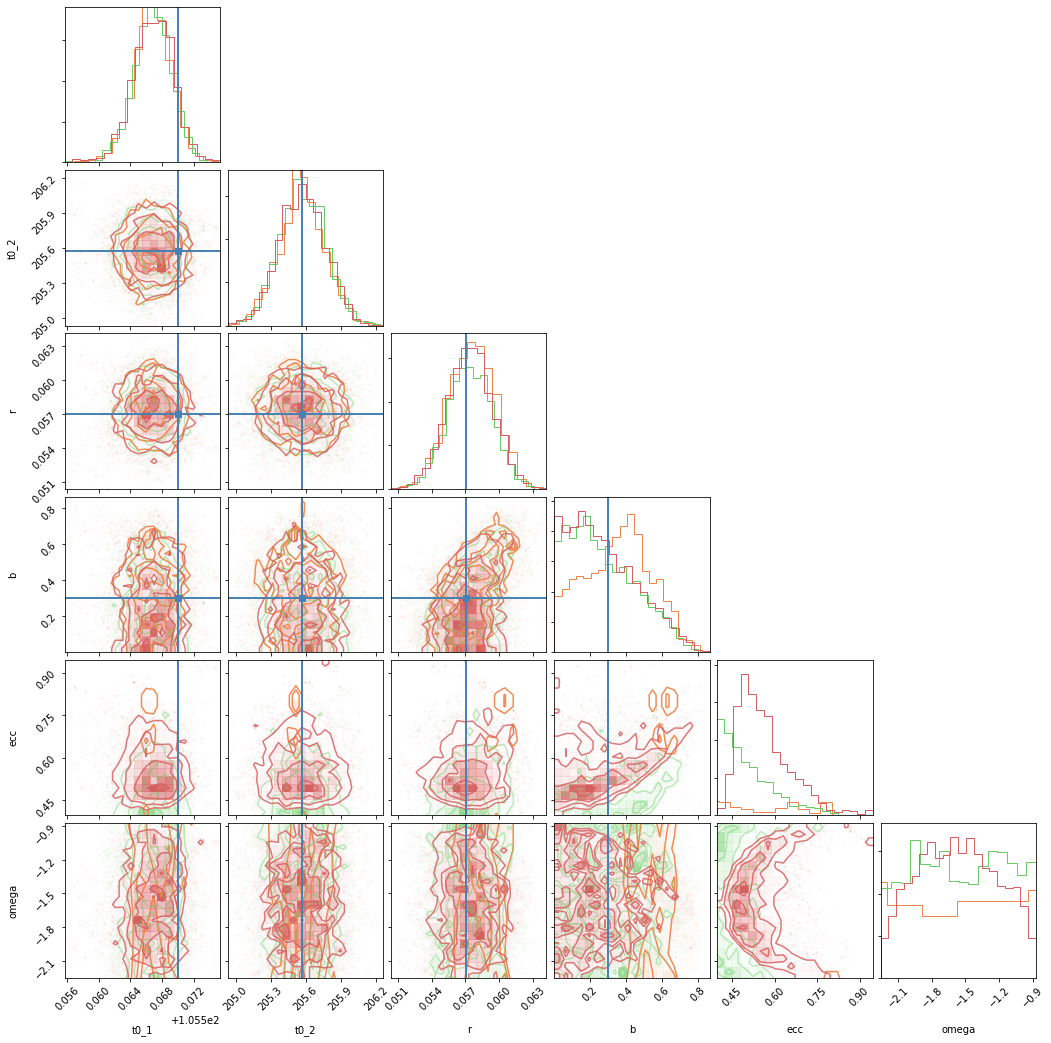

In [30]:
figures[3]

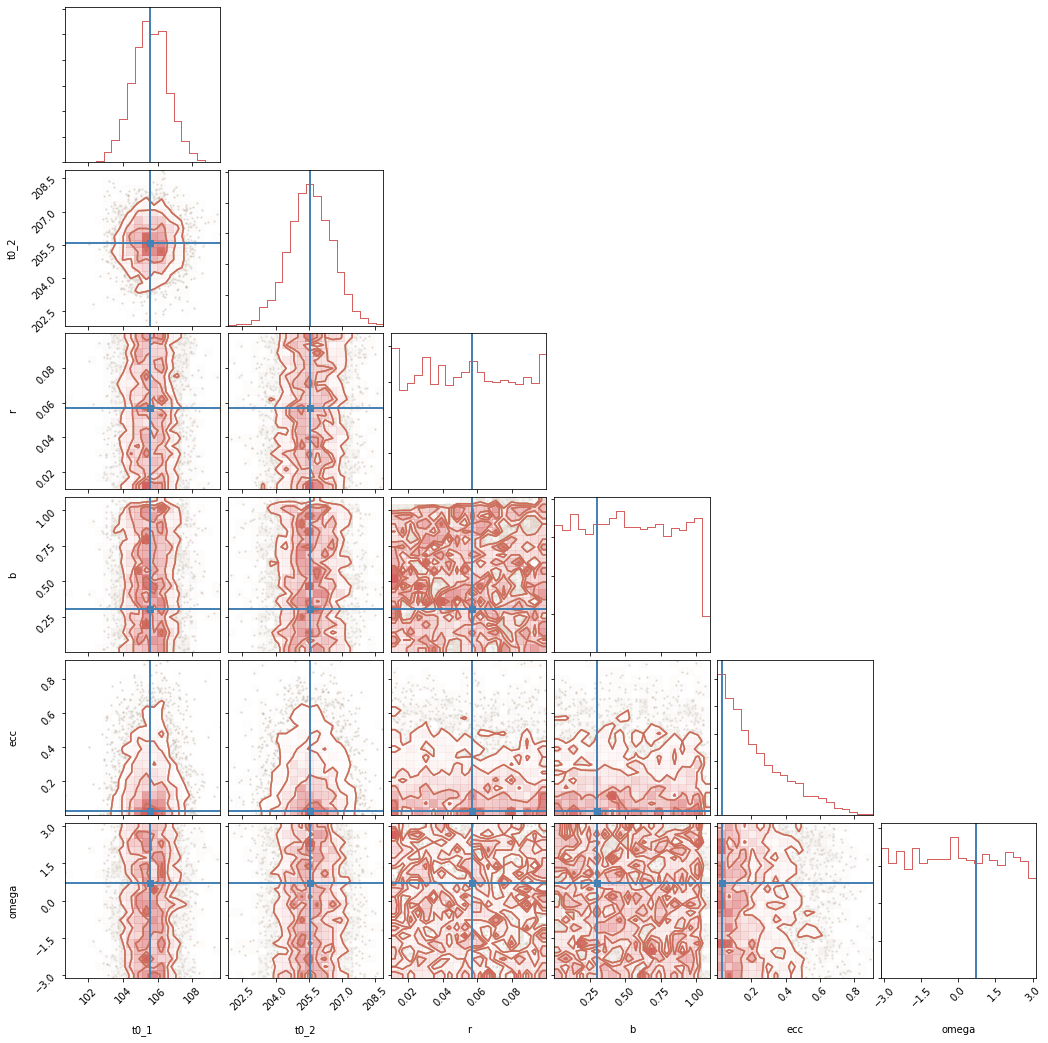

In [22]:
figures[[100,33.3333333,10,5.88235294][0]]

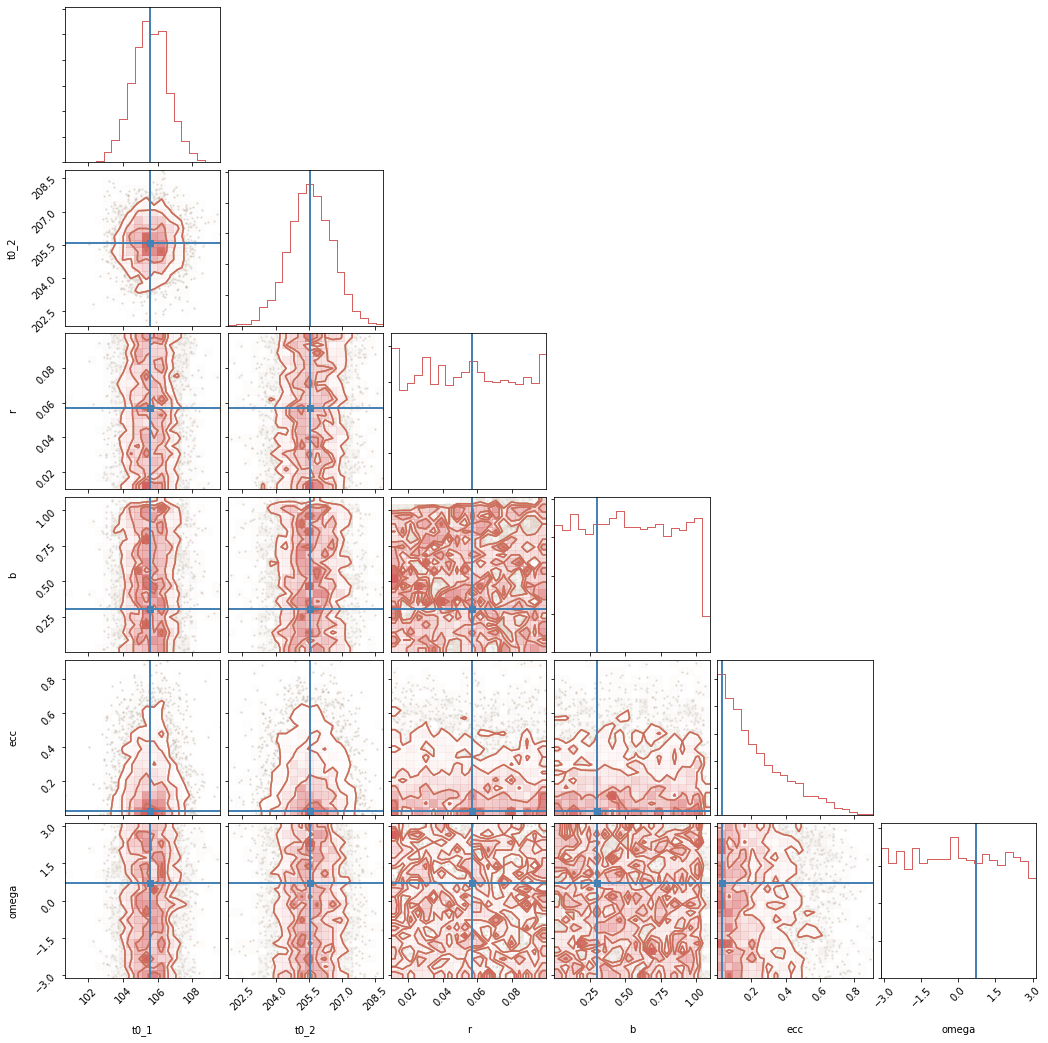

In [23]:
figures[[100,33.3333333,10,5.88235294][1]]

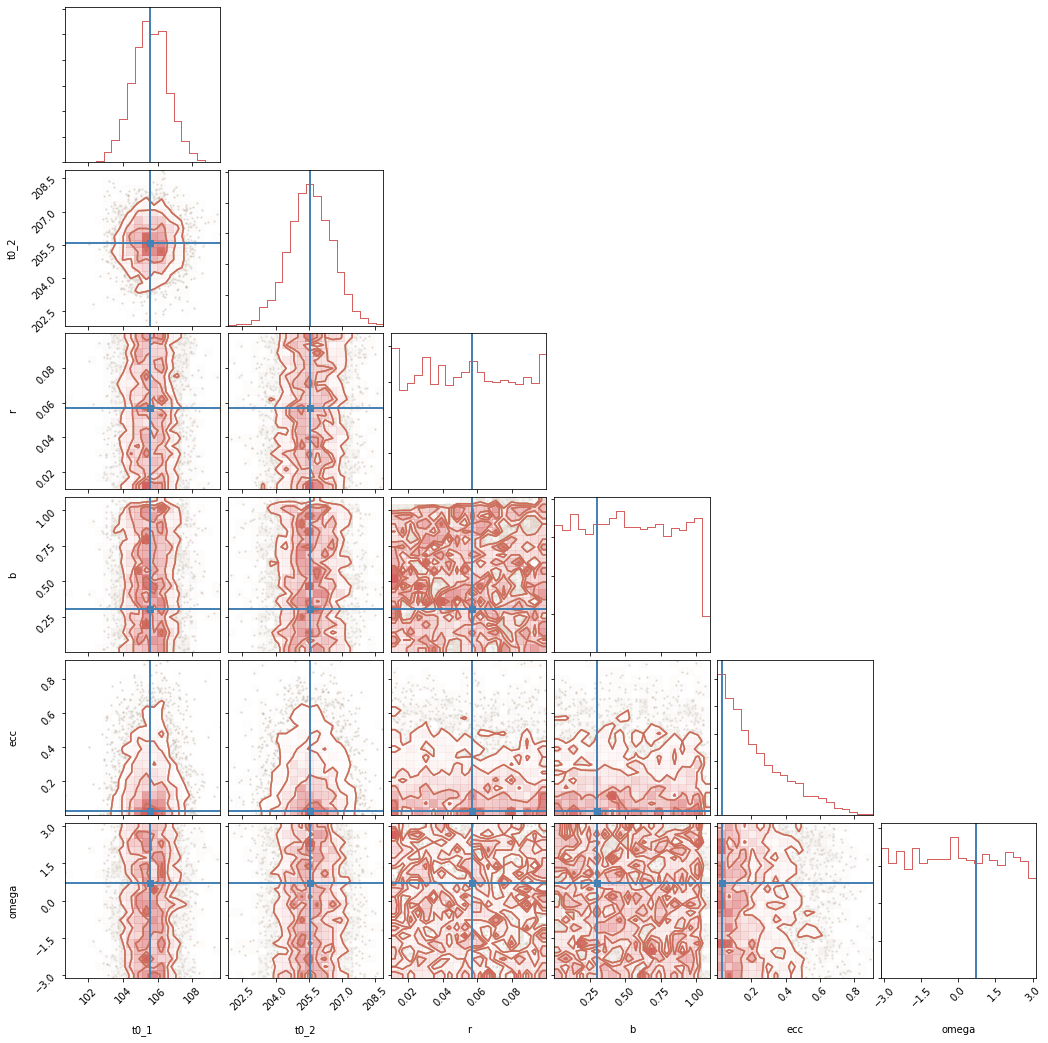

In [24]:
figures[[100,33.3333333,10,5.88235294][2]]

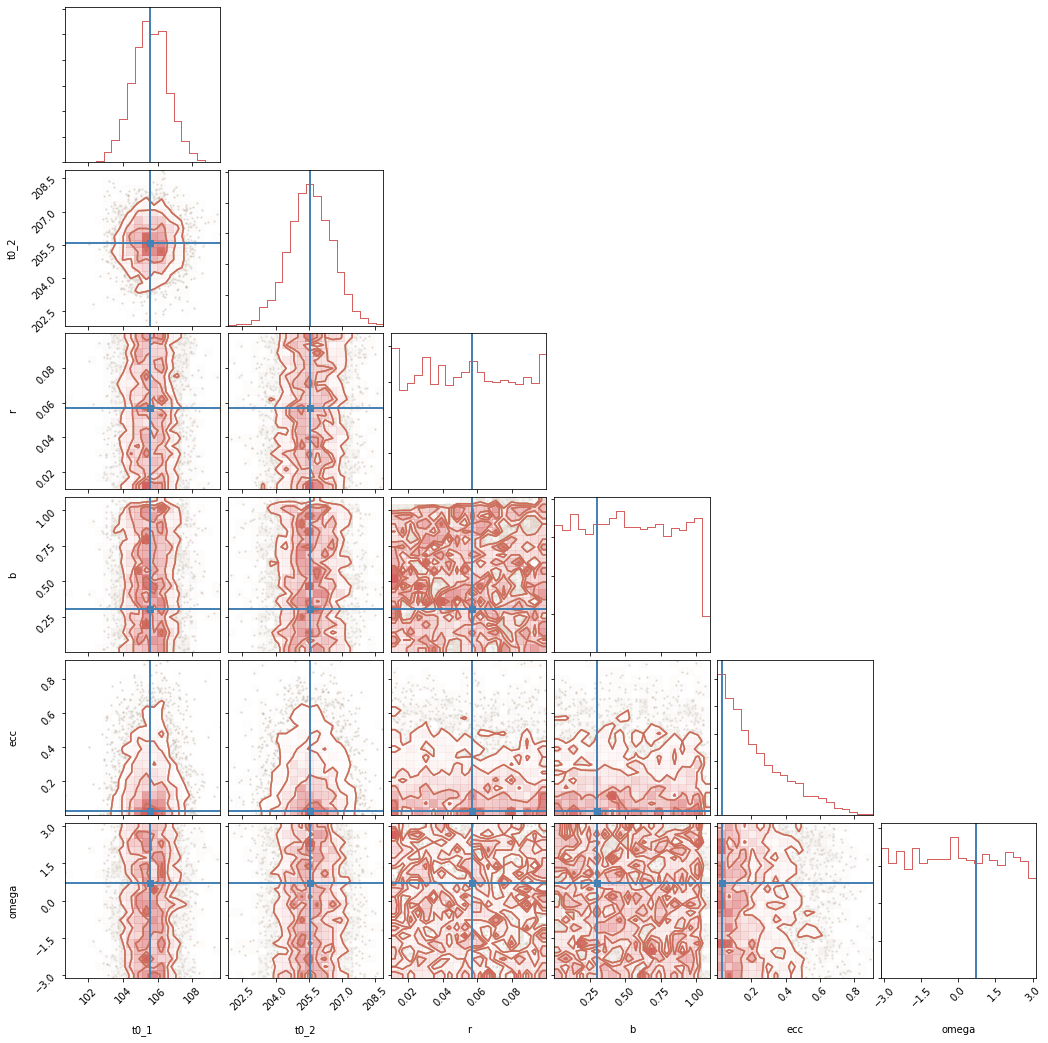

In [25]:
figures[[100,33.3333333,10,5.88235294][3]]

<IPython.core.display.Javascript object>


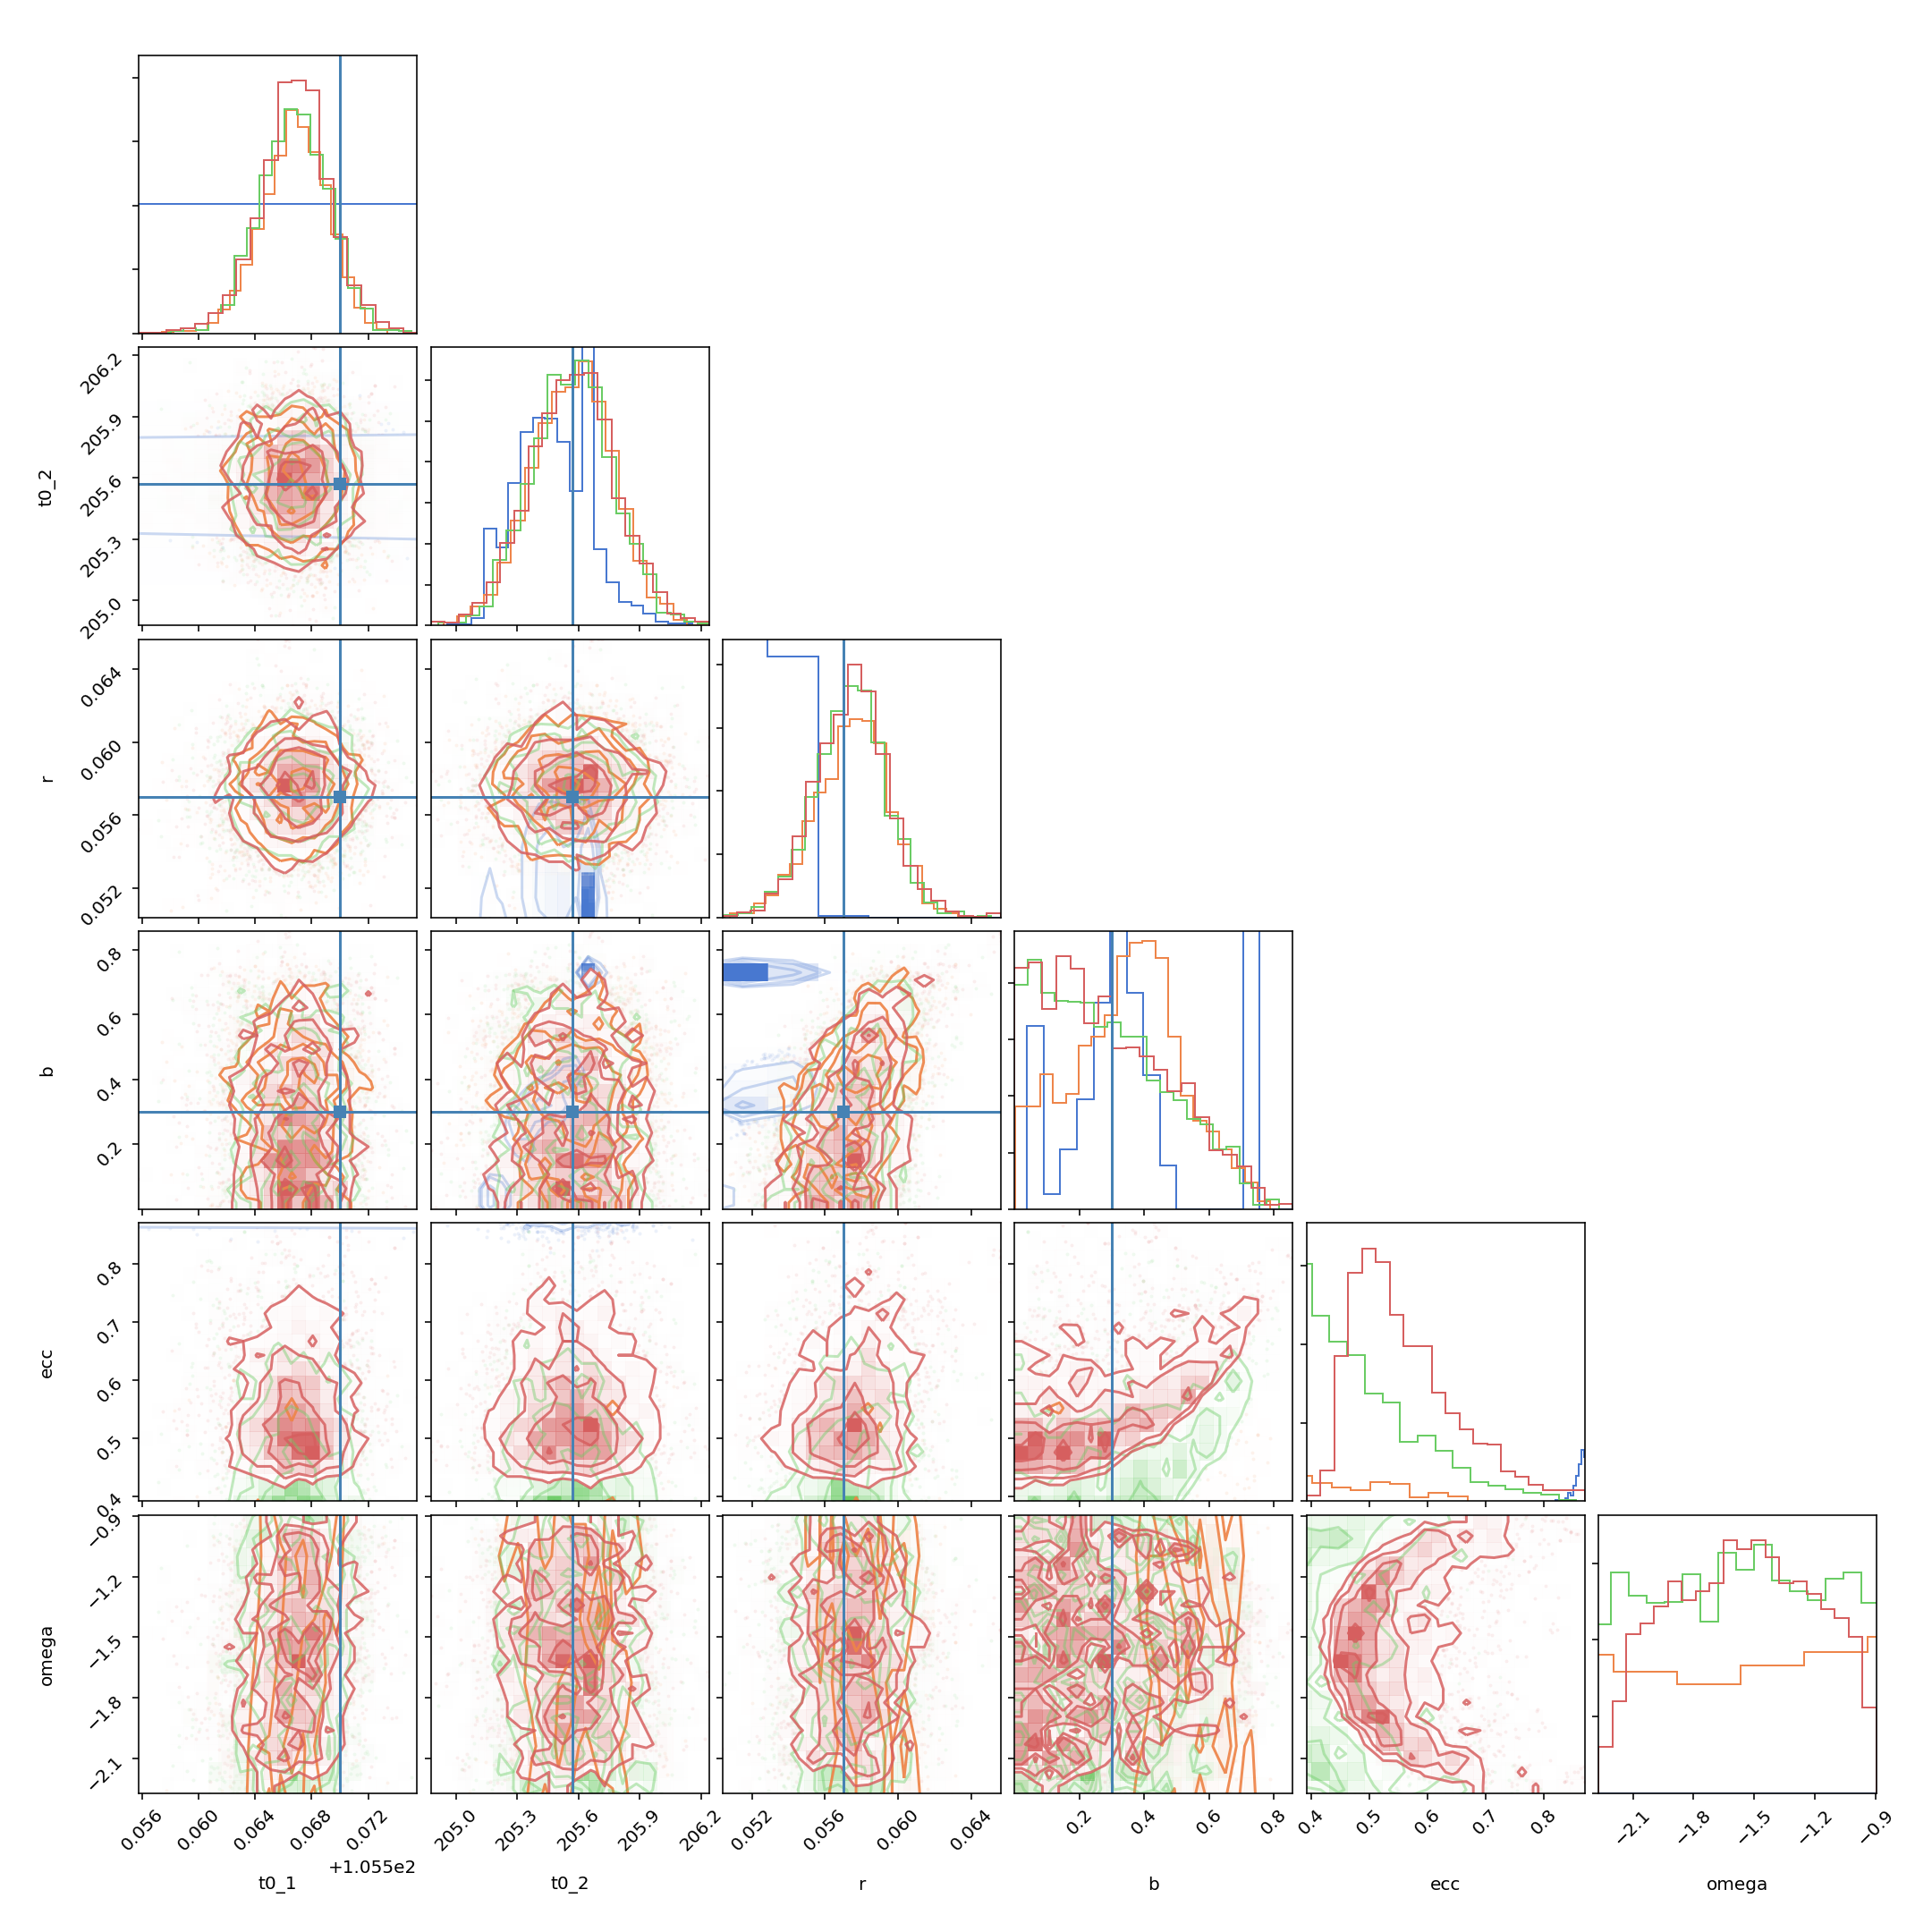

In [3]:
import pickle
with open("marg_all_data.pickle","rb") as pickle_file:
    out = pickle.load(pickle_file)

In [4]:
models,optimized,traces,samples=out[:4]

In [5]:
import corner

In [ ]:
weight_samps = np.exp(trace["logprob_class"].flatten())


In [ ]:
ni=2
samples[ni] = pm.trace_to_dataframe(traces[ni], varnames=["t0_1", "t0_2", "r", "b","ecc","omega","lnprob"])
figures[ni]=corner.corner(samples[ni], 
                         labels=["t0_1", "t0_2", "r", "b","ecc","omega"], 
                         truths=np.concatenate((t0s, [np.sqrt(0.00325), 0.3, 0.025, 0.72])),
                         fig=fig,color=sns.color_palette()[ni])
